# Importing NN modules and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/NeuralNetwork")

In [2]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import numpy as np
import random
import copy
import torch.optim as optim
import pickle
import os
import pandas as pd
import time
import matplotlib.pyplot as plt

from library_model import layers as lay
from library_model import model_building as mb
from library_model import model_training as mt
from data import data_loading as dt
from data import text as txt

In [4]:
%%bash
pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 78.9 MB/s eta 0:00:00


In [5]:
%%bash
pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')

# Define Network State

In [4]:
state = lay.Network_state()
p= state.parameters
tr= state.training

p.d_model=200
p.d_hid=200
p.nheads=2
p.d_key = p.d_model //p.nheads
p.nlayers=2


tr.batch_size=20
tr.data_fraction = 0.8
tr.lr = 1.
tr.seq_length=35
tr.optimizer = "sgd"
tr.schedule = mb.learning_rate_step(5., 20/19, 1)

# Process Data

In [5]:
d = dt.Data()
d.tokenizer, d.train_dataloader, d.test_dataloader = dt.process_data(train_iter, txt.library_text_coders, state, network = "encoder") #switch to transformer if interested in encoder/decoder model
p.ntokens = p.ntokens_out = len(d.tokenizer.vocab)

Data instance

In [8]:
#train
([a1], b1) = next(iter(d.train_dataloader))
d.decode(a1[5])

"out lbw if the ball would have struck the wicket , but was instead intercepted by any part of the batsman ' s body ( except the hand holding the bat ) . the"

In [9]:
#test
([a2], b2) = next(iter(d.test_dataloader))
d.decode(a2[5])

'the southeast . as the storm moved at a rapid speed towards the coastline of western australia , it began to undergo an extratropical transition . during a 24 @-@ hour period ( 20'

# Construct Models

In [10]:
parts = mb.get_transformer_parts(state)
model = lay.EncoderModel(parts.encoder, parts.linear).to(state.device)
#transformer = lay.Transformer(parts.encoder, parts.decoder, parts.linear).to(state.device)

# Train Models

In [11]:
opt, scheduler = mb.get_optimizer(state, model)
criterion = nn.CrossEntropyLoss()
train = mt.Model_training(model, opt, criterion, scheduler)

Batch 200 | lr = 5.0 | time =  0.08 | train_loss  8.87
Batch 400 | lr = 5.0 | time =  0.09 | train_loss  7.78
Batch 600 | lr = 5.0 | time =  0.09 | train_loss  7.43
Batch 800 | lr = 5.0 | time =  0.08 | train_loss  7.33
Batch 1000 | lr = 5.0 | time =  0.08 | train_loss  7.19
Batch 1200 | lr = 5.0 | time =  0.08 | train_loss  7.09
Batch 1400 | lr = 5.0 | time =  0.10 | train_loss  7.01
Batch 1600 | lr = 5.0 | time =  0.07 | train_loss  6.97
Batch 1800 | lr = 5.0 | time =  0.08 | train_loss  6.86
Batch 2000 | lr = 5.0 | time =  0.09 | train_loss  6.85
Batch 2200 | lr = 5.0 | time =  0.09 | train_loss  6.78
Epoch: 0 | time: 41.41 | test_loss =  6.94

Batch 200 | lr = 4.75 | time =  0.07 | train_loss  6.67
Batch 400 | lr = 4.75 | time =  0.09 | train_loss  6.65
Batch 600 | lr = 4.75 | time =  0.09 | train_loss  6.66
Batch 800 | lr = 4.75 | time =  0.09 | train_loss  6.58
Batch 1000 | lr = 4.75 | time =  0.08 | train_loss  6.58
Batch 1200 | lr = 4.75 | time =  0.09 | train_loss  6.57
Batch 

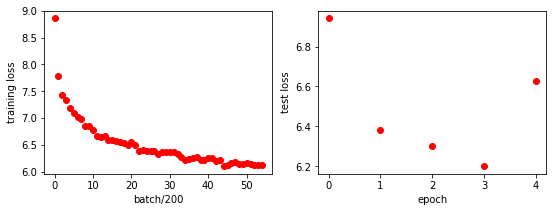

In [14]:
train(epochs = 5, data = d)

# Pytorch tutorial model  (code copied from pytorch tutorial for comparison)

In [ ]:
#@title
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(torch.device("cuda"))

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x).to(torch.device("cuda"))

In [ ]:
tutorial_model = TransformerModel(p.ntokens, p.d_model,p.nheads, p.d_hid, p.nlayers, dropout=0.2).to(state.device)

In [ ]:
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [ ]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len].transpose(0,1)
    target = source[i+1:i+1+seq_len].transpose(0,1).reshape(-1)
    return data, target

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer2 = torch.optim.SGD(tutorial_model.parameters(), lr=lr)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, 1.0, gamma=0.95)
bptt = 35

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(1)
        src_mask = generate_square_subsequent_mask(seq_len)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, p.ntokens), targets)

        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer2.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler2.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [ ]:
for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(tutorial_model)
        scheduler2.step()

| epoch   1 |   200/ 2928 batches | lr 4.29 | ms/batch 15.76 | loss  8.16 | ppl  3509.78
| epoch   1 |   400/ 2928 batches | lr 4.29 | ms/batch 14.94 | loss  6.88 | ppl   975.42
| epoch   1 |   600/ 2928 batches | lr 4.29 | ms/batch 14.88 | loss  6.41 | ppl   608.47
| epoch   1 |   800/ 2928 batches | lr 4.29 | ms/batch 14.94 | loss  6.25 | ppl   518.87
| epoch   1 |  1000/ 2928 batches | lr 4.29 | ms/batch 15.20 | loss  6.15 | ppl   470.09
| epoch   1 |  1200/ 2928 batches | lr 4.29 | ms/batch 15.41 | loss  6.11 | ppl   451.18
| epoch   1 |  1400/ 2928 batches | lr 4.29 | ms/batch 16.51 | loss  6.09 | ppl   441.12
| epoch   1 |  1600/ 2928 batches | lr 4.29 | ms/batch 15.07 | loss  6.07 | ppl   432.16
| epoch   1 |  1800/ 2928 batches | lr 4.29 | ms/batch 15.21 | loss  5.98 | ppl   396.23
| epoch   1 |  2000/ 2928 batches | lr 4.29 | ms/batch 15.63 | loss  5.97 | ppl   391.47
| epoch   1 |  2200/ 2928 batches | lr 4.29 | ms/batch 16.04 | loss  5.86 | ppl   351.62
| epoch   1 |  2400/ 

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


| epoch   2 |   200/ 2928 batches | lr 4.07 | ms/batch 14.97 | loss  5.84 | ppl   345.15
| epoch   2 |   400/ 2928 batches | lr 4.07 | ms/batch 14.82 | loss  5.80 | ppl   331.88
| epoch   2 |   600/ 2928 batches | lr 4.07 | ms/batch 14.84 | loss  5.58 | ppl   266.13
| epoch   2 |   800/ 2928 batches | lr 4.07 | ms/batch 15.27 | loss  5.60 | ppl   270.89
| epoch   2 |  1000/ 2928 batches | lr 4.07 | ms/batch 15.03 | loss  5.56 | ppl   258.95
| epoch   2 |  1200/ 2928 batches | lr 4.07 | ms/batch 14.76 | loss  5.60 | ppl   269.39
| epoch   2 |  1400/ 2928 batches | lr 4.07 | ms/batch 14.79 | loss  5.62 | ppl   275.48
| epoch   2 |  1600/ 2928 batches | lr 4.07 | ms/batch 14.92 | loss  5.65 | ppl   284.40
| epoch   2 |  1800/ 2928 batches | lr 4.07 | ms/batch 15.28 | loss  5.59 | ppl   266.66
| epoch   2 |  2000/ 2928 batches | lr 4.07 | ms/batch 14.78 | loss  5.59 | ppl   266.60
| epoch   2 |  2200/ 2928 batches | lr 4.07 | ms/batch 14.77 | loss  5.49 | ppl   242.56
| epoch   2 |  2400/ 